# Standardize Data

### Libraries

In [1]:
import numpy as np
import pandas as pd
import sqlite3
from sklearn import preprocessing

In [28]:
import matplotlib.pyplot as plt

### Import Data

In [278]:
conn = sqlite3.connect('../data/crime_census_weather_tod.db')
df = pd.read_sql_query("select * from all_crimes", conn)
conn.close()

In [279]:
df.columns

Index(['level_0', 'BLOCK_GROUP', 'year', 'month', 'day', 'tod', 'crime_counts',
       'apparent_temp', 'cloud_cover', 'dew_point', 'humidity',
       'percip_intensity', 'percip_probability', 'pressure', 'temperature',
       'uv_index', 'visibility', 'wind_bearing', 'wind_gust', 'wind_speed',
       'weekday', 'index', 'TotalPop', 'TPopMargin', 'UnWgtSampleCtPop',
       'PerCapitaIncome', 'PerCapIncMargin', 'MedianHouseholdInc',
       'MedHouseholdIncMargin', 'MedianAge', 'MedianAgeMargin', 'HousingUnits',
       'HousingUnitsMargin', 'UnweightedSampleHousingUnits', 'State', 'County',
       'Tract', 'BlockGroup', 'census_year', 'crime_rate'],
      dtype='object')

### Encode

Encode Blockgroup, which includes an embedded Tract.

In [21]:
le = preprocessing.LabelEncoder()

In [22]:
bg_fit = le.fit(df_d['BLOCK_GROUP'])

In [23]:
df_d['bg_cat'] = bg_fit.transform(df_d['BLOCK_GROUP'])

In [24]:
print(df_d.columns, len(df_d.columns))

Index(['BLOCK_GROUP', 'year', 'month', 'day', 'tod', 'cloud_cover',
       'dew_point', 'humidity', 'percip_intensity', 'percip_probability',
       'pressure', 'temperature', 'uv_index', 'visibility', 'wind_bearing',
       'wind_gust', 'wind_speed', 'TotalPop', 'PerCapitaIncome',
       'MedianHouseholdInc', 'MedianAge', 'HousingUnits', 'crime_rate',
       'weekday', 'tod_cat', 'bg_cat'],
      dtype='object') 26


### Create Crime Rate Category (Target)

Standardize Crime Rate

In [41]:
standardize = df_d[['crime_rate']]
power = preprocessing.PowerTransformer(method='box-cox', standardize=False)

df_d['crs'] = power.fit_transform(standardize)

Plot Differences

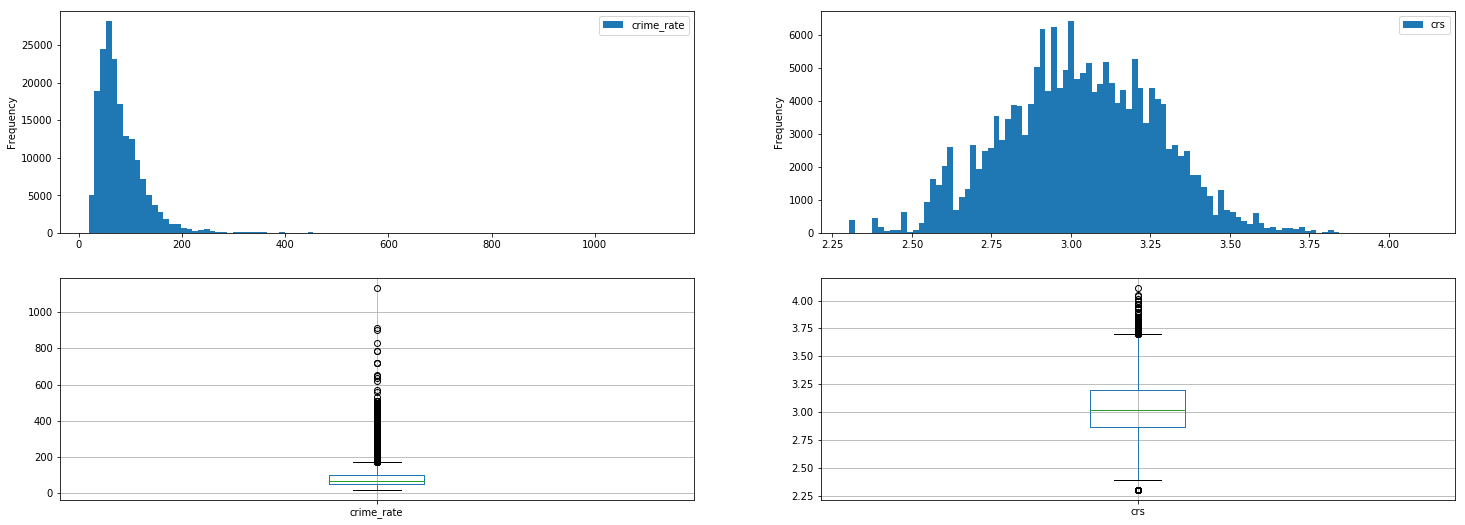

In [42]:
fig = plt.figure(figsize=(25,9))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

df_d[['crime_rate']].plot(kind='hist', bins=100, ax=ax1)
df_d[['crs']].plot(kind='hist', bins=100, ax=ax2)
df_d[['crime_rate']].boxplot(ax=ax3)
df_d[['crs']].boxplot(ax=ax4)

Set Crime Rate Categories

In [89]:
stats = df_d[['crs']].describe().transpose()
stats['high-cutoff'] = stats['mean'] + 2*stats['std']
stats['med-high-cutoff'] = stats['mean'] + 2*stats['std']

,count,mean,std,min,25%,50%,75%,max
crs,179382.0,3.028244,0.241698,2.303395,2.867692,3.022922,3.20087,4.115983


In [103]:
def classifyCrimeRates(row, stats):
    range_high = float(stats['mean'] + 2*stats['std'])
    range_mid_high = float(stats['mean'] + stats['std'])
    range_mid_low = float(stats['mean'] - stats['std'])
    range_low = float(stats['mean'] - 2*stats['std'])
    cr = float(row['crs'])
    
    if cr >= range_high:
        crime_rate_cat = 'High'
    if cr >= range_mid_high and cr < range_high:
        crime_rate_cat = 'Med-High'
    if cr >= range_mid_low and cr < range_mid_high:
        crime_rate_cat = 'Med'
    if cr >= range_low and cr < range_mid_low:
        crime_rate_cat = 'Low-Med'
    if cr < range_low:
        crime_rate_cat = 'Low'
    
    return crime_rate_cat

In [105]:
df_d['crime_rate_cat'] = df_d[['crs']].apply(classifyCrimeRates, args=(stats[['mean','std']],), axis=1)

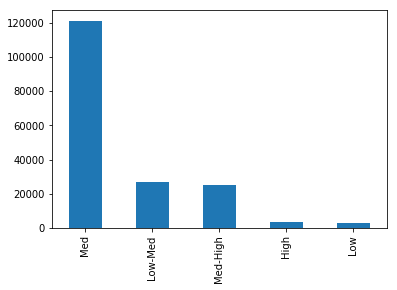

In [106]:
df_d['crime_rate_cat'].value_counts().plot(kind='bar')

In [107]:
df_d.columns

Index(['BLOCK_GROUP', 'year', 'month', 'day', 'tod', 'cloud_cover',
       'dew_point', 'humidity', 'percip_intensity', 'percip_probability',
       'pressure', 'temperature', 'uv_index', 'visibility', 'wind_bearing',
       'wind_gust', 'wind_speed', 'TotalPop', 'PerCapitaIncome',
       'MedianHouseholdInc', 'MedianAge', 'HousingUnits', 'crime_rate',
       'weekday', 'tod_cat', 'bg_cat', 'crs', 'crime_rate_cat'],
      dtype='object')

### Standardize Features

Drop missing values.

In [113]:
df_m = df_d.dropna(how='any')

In [114]:
print(len(df_d),len(df_m), len(df)-len(df_m))

179382 179382 8842


Set Features and Target.

In [202]:
feature_cols = [
    'year', 'month', 'day', 'tod_cat',
    'cloud_cover', 'dew_point', 'humidity', 'percip_intensity',
    'percip_probability', 'pressure', 'temperature', 'uv_index',
    'visibility', 'wind_bearing', 'wind_gust', 'wind_speed',
    'PerCapitaIncome', 'MedianHouseholdInc', 'MedianAge', 'HousingUnits',
    'weekday', 'bg_cat'
]

target_cols = 'crime_rate_cat'

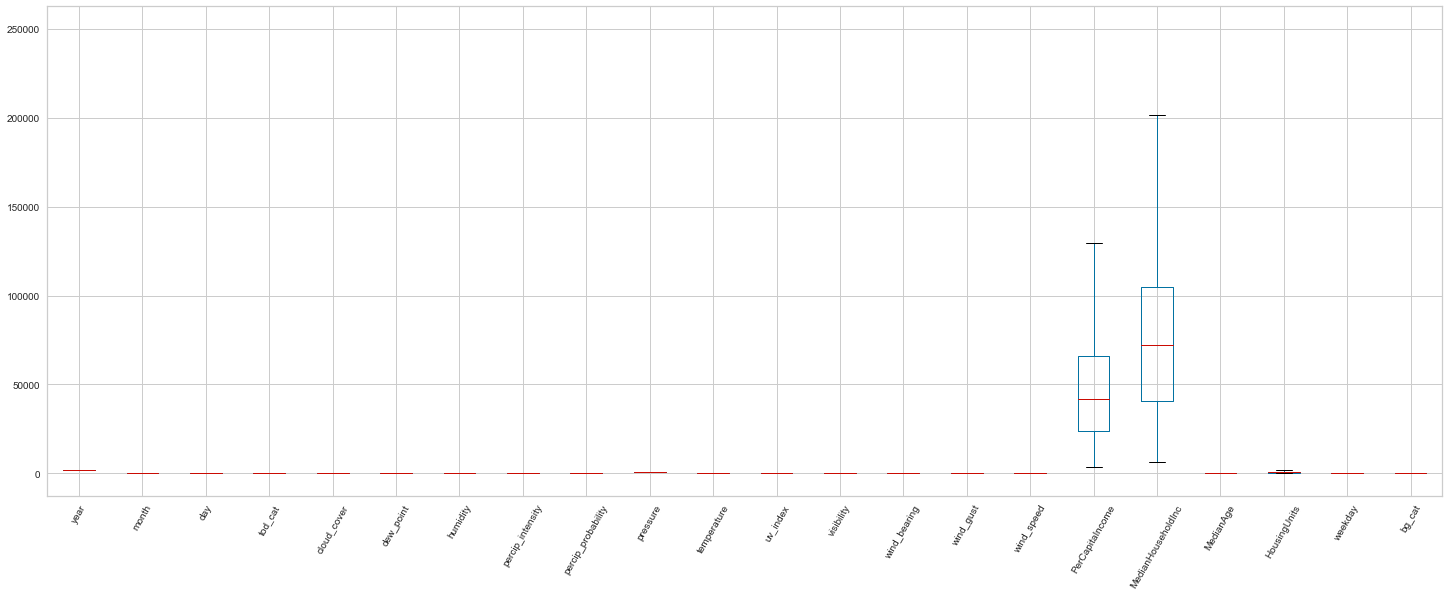

In [185]:
fig = plt.figure(figsize=(25,9))
ax1 = fig.add_subplot(1,1,1)

df_m[feature_cols].boxplot(ax=ax1, rot=60)

Standardize Features

In [186]:
scaler = preprocessing.StandardScaler()
robust = preprocessing.RobustScaler()
minmax = preprocessing.MinMaxScaler()

scaler_df = pd.DataFrame(scaler.fit_transform(df_m[feature_cols]), columns=feature_cols)
robust_df = pd.DataFrame(robust.fit_transform(df_m[feature_cols]), columns=feature_cols)
minmax_df = pd.DataFrame(minmax.fit_transform(df_m[feature_cols]), columns=feature_cols)

C:\Users\Barbieri\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Barbieri\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Barbieri\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


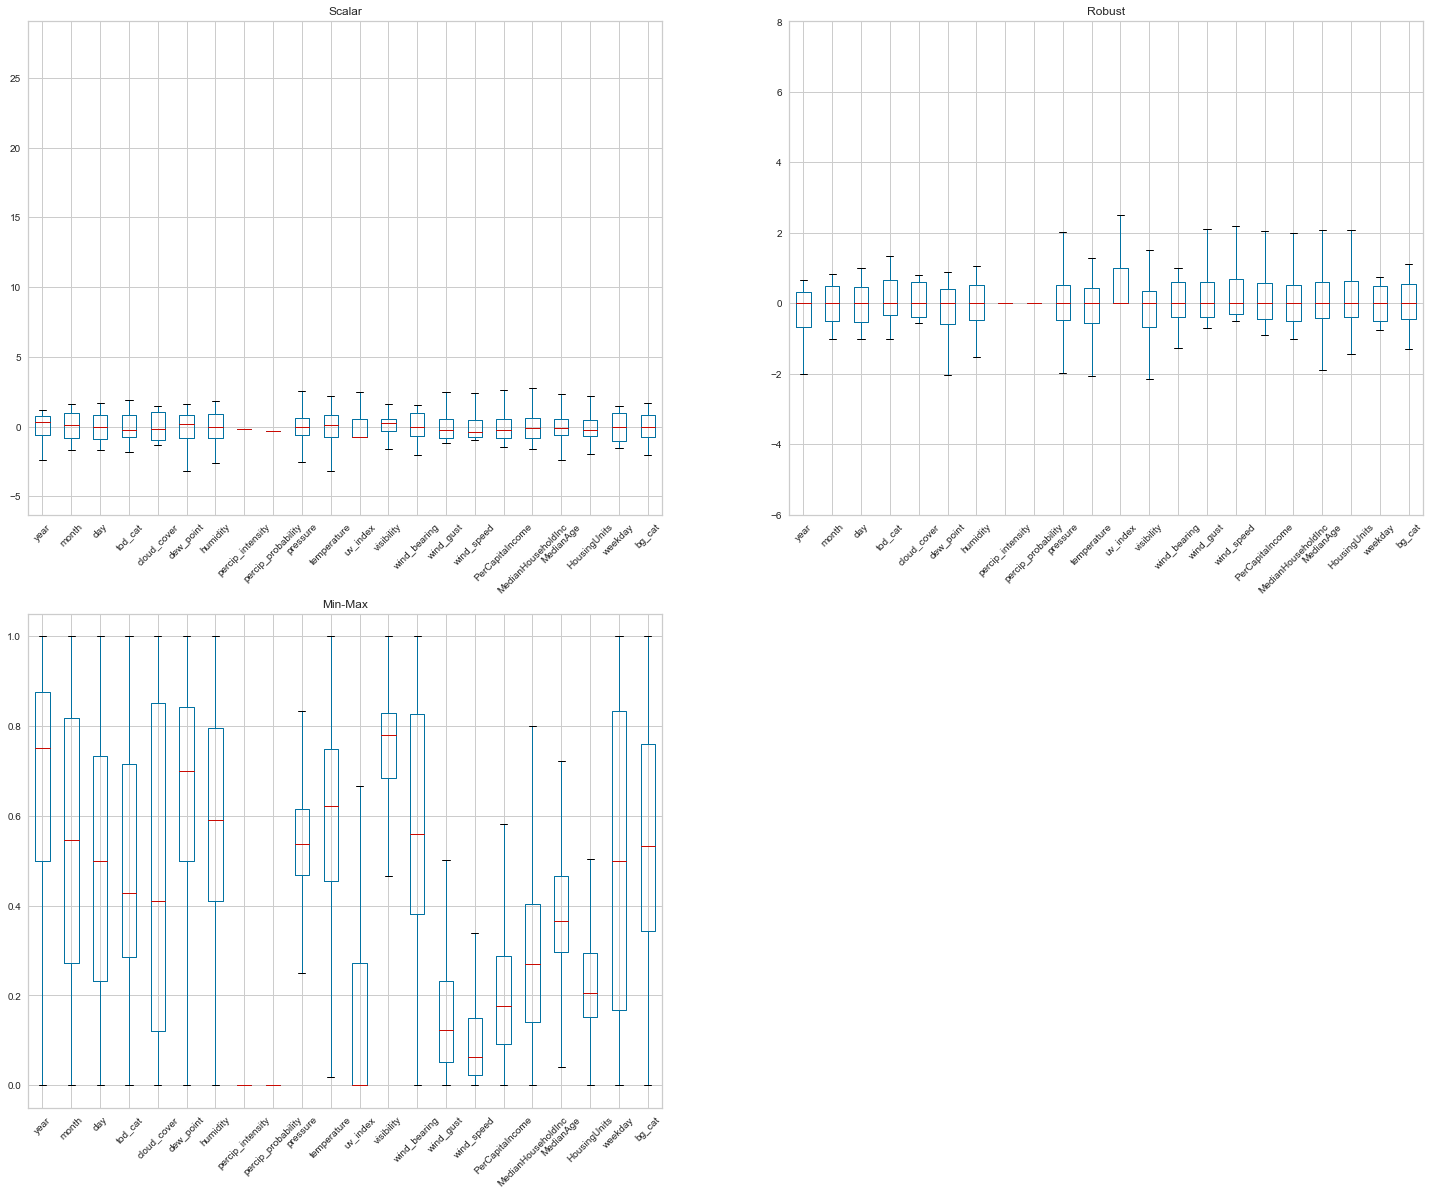

In [187]:
fig = plt.figure(figsize=(25,20))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)

scaler_df.boxplot(ax=ax1)
robust_df.boxplot(ax=ax2)
minmax_df.boxplot(ax=ax3)

ax1_labels = ax1.get_xticklabels()
ax2_labels = ax2.get_xticklabels()
ax3_labels = ax3.get_xticklabels()

ax1.set_xticklabels(ax1_labels,rotation=45)
ax2.set_xticklabels(ax2_labels,rotation=45)
ax3.set_xticklabels(ax3_labels,rotation=45)

ax1.title.set_text('Scalar')
ax2.title.set_text('Robust')
ax3.title.set_text('Min-Max')

plt.show()

### Feature Selection

In [188]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

In [204]:
features_scaled = scaler_df
target = df_m[target_cols]

#### Feature ranking

Feature ranking with recursive feature elimination and cross-validated selection for the best number of features.

Random Forest Classifier

In [266]:
rmf = RandomForestClassifier()
rfecv = RFECV(estimator=rmf,
              step=1,
              cv=StratifiedKFold(12),
              scoring='accuracy',
              verbose=10, n_jobs=-1)

In [267]:
rfecv.fit(features_scaled, target)
print(rfecv.n_features_)

Fitting estimator with 11 features.


C:\Users\Barbieri\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 10 features.


C:\Users\Barbieri\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 9 features.


C:\Users\Barbieri\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Barbieri\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Barbieri\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


8


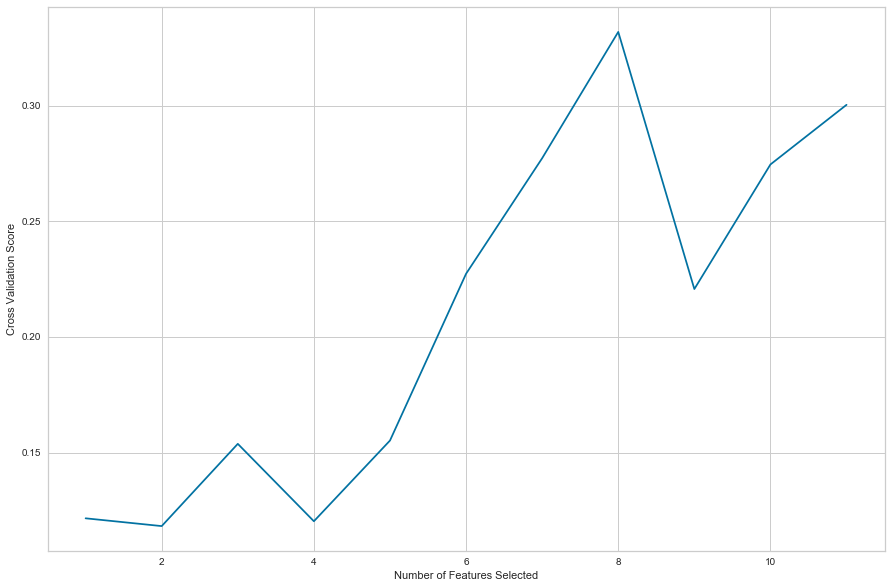

In [268]:
plt.figure(figsize=(15, 10))
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross Validation Score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [269]:
for index in np.where(rfecv.support_)[0]:
    print(features_scaled.columns[index])

month
day
tod_cat
humidity
temperature
uv_index
weekday
bg_cat


### Modeling

In [241]:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Ridge

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [270]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2)

In [271]:
classes=target.unique()

list(classes)

['Med', 'High', 'Med-High', 'Low', 'Low-Med']

C:\Users\Barbieri\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


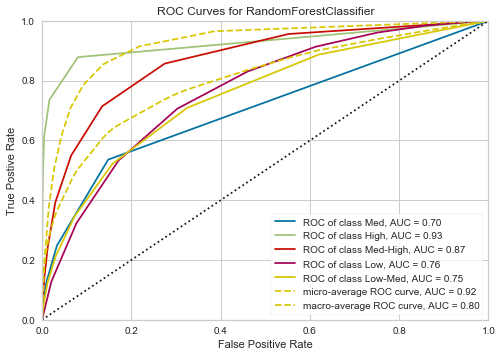

In [272]:
from yellowbrick.classifier import ROCAUC
#from sklearn.tree import LogisticReg

classes=list(target.unique())

# Instantiate the visualizer with the classification model
visualizer = ROCAUC(RandomForestClassifier(), classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()   